In [65]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.metrics import RootMeanSquaredError as rms

import os
import matplotlib.pyplot as plt
AUTO = tf.data.AUTOTUNE

In [3]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2025-02-08 18:58:36.486702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2446 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6
2025-02-08 18:58:36.487190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22214 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [4]:
base_dir = '../ML Research/ILSVRC/Data/CLS-LOC'
train_dir = os.path.join(base_dir, 'train/')
val_dir = os.path.join(base_dir, 'val/')
test_dir = os.path.join(base_dir, 'test/')

## ImageNet Dataset Creation:

In [5]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync

In [6]:
def process_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3) 
    image = tf.image.resize(image, (160, 160))

    grayscale = rgb_to_grayscale(image)
    
    grayscale = (grayscale / 127.5) - 1
    image = (image / 127.5) - 1

    return grayscale, image

In [7]:
os.listdir(test_dir)[:5]

['ILSVRC2012_test_00022959.JPEG',
 'ILSVRC2012_test_00071972.JPEG',
 'ILSVRC2012_test_00000824.JPEG',
 'ILSVRC2012_test_00045324.JPEG',
 'ILSVRC2012_test_00081438.JPEG']

In [20]:
def get_dataset(path, batch_size):
    if (path.split('/')[-2] == "test"):
        image_paths = tf.data.Dataset.list_files(path + "*.JPEG", shuffle=True)
    else:
        image_paths = tf.data.Dataset.list_files(path + "*/*.JPEG", shuffle=True)
    dataset = image_paths.map(process_image, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size).prefetch(AUTO)
    return dataset

In [21]:
train_data = get_dataset(train_dir, batch_size=BATCH_SIZE)

In [25]:
train_data.cardinality().numpy() * BATCH_SIZE

1281280

In [26]:
val_data = get_dataset(val_dir, batch_size=BATCH_SIZE)

In [27]:
val_data.cardinality().numpy() * BATCH_SIZE

50176

In [22]:
test_data = get_dataset(test_dir, batch_size=BATCH_SIZE)

In [24]:
test_data.cardinality().numpy()

391

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


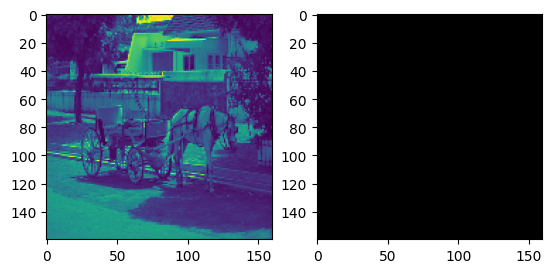

In [66]:
for batch in test_data.as_numpy_iterator():
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(batch[0][0] / 255)
    axs[1].imshow(batch[1][0] / 255)
    break

## Model Experimentation:

In [60]:
class encoder_block(tf.keras.Model):
    def __init__(self, filters=64, kernel_size=(3, 3), pool_size=2, padding='same'):
        super(encoder_block, self).__init__()
        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu')
        self.conv_2 = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu')
        self.max_pool = MaxPooling2D(pool_size=pool_size)

    def call(self, inputs):
        x = self.conv_1(inputs)
        skip = self.conv_2(x)
        output = self.max_pool(skip)

        return skip, output

In [61]:
class decoder_block(tf.keras.Model):
    def __init__(self, filters=64, kernel_size=(3, 3), padding='same'):
        super(decoder_block, self).__init__()
        self.conv_t = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding=padding)
        self.concat = Concatenate()
        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu')
        self.conv_2 = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu')

    def call(self, skip_input, inputs):
        upsample = self.conv_t(inputs)
        merged = self.concat([upsample, skip_input])
        x = self.conv_1(merged)
        output = self.conv_2(x)
        return output

In [62]:
class UNet(tf.keras.Model):
    def __init__(self, input_size=(160, 160, 1), padding='same'):
        super(UNet, self).__init__()
        self.encoder_1 = encoder_block(filters=64)
        self.encoder_2 = encoder_block(filters=128)
        self.encoder_3 = encoder_block(filters=256)
        self.encoder_4 = encoder_block(filters=512)
        self.bottleneck_conv1 = Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding=padding)
        self.bottleneck_conv2 = Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding=padding)
        self.decoder_1 = decoder_block(filters=512)
        self.decoder_2 = decoder_block(filters=256)
        self.decoder_3 = decoder_block(filters=128)
        self.decoder_4 = decoder_block(filters=64)
        self.final_conv = Conv2D(filters=3, kernel_size=(1, 1), padding='same')

    def call(self, inputs):
        skip_4, x = self.encoder_1(inputs)
        skip_3, x = self.encoder_2(x)
        skip_2, x = self.encoder_3(x)
        skip_1, x = self.encoder_4(x)
        x = self.bottleneck_conv1(x)
        x = self.bottleneck_conv2(x)
        x = self.decoder_1(skip_1, x)
        x = self.decoder_2(skip_2, x)
        x = self.decoder_3(skip_3, x)
        x = self.decoder_4(skip_4, x)
        output = self.final_conv(x)
        return output

In [63]:
model = UNet()

In [64]:
model.compile(optimizer='adam', loss='mse', metrics=rms())
model.predict(tf.ones(shape=(3, 160, 160, 1)))
model.summary()

2025-02-08 22:16:34.627894: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-02-08 22:16:34.846611: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 2s 2s/step
Model: "u_net_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_block_22 (encoder_  multiple                  37568     
 block)                                                          
                                                                 
 encoder_block_23 (encoder_  multiple                  221440    
 block)                                                          
                                                                 
 encoder_block_24 (encoder_  multiple                  885248    
 block)                                                          
                                                                 
 encoder_block_25 (encoder_  multiple                  3539968   
 block)                                                          
                                                                 
 conv2d_9

2025-02-08 22:16:35.676277: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-08 22:16:35.704477: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 block)                                                          
                                                                 
 decoder_block_18 (decoder_  multiple                  2294528   
 block)                                                          
                                                                 
 decoder_block_19 (decoder_  multiple                  573824    
 block)                                                          
                                                                 
 decoder_block_20 (decoder_  multiple                  143552    
 block)                                                          
                                                                 
 conv2d_106 (Conv2D)         multiple                  195       
                                                                 
Total params: 31030723 (118.37 MB)
Trainable params: 31030723 (118.37 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________